### CNN 활용_skin_cancer_MNIST

In [46]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

import os
from PIL import Image
import seaborn as sns
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [10]:
df = pd.read_csv('./HAM10000_metadata.csv')

In [12]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [14]:
df.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

In [16]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [17]:
# Data Cleaning

df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [18]:
df['age'].fillna(int(df['age'].mean()), inplace=True)

In [19]:
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [31]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = './'

# Merge images from both folders into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [34]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,.\HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,.\HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,.\HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,.\HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,.\HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [36]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((125,100))))

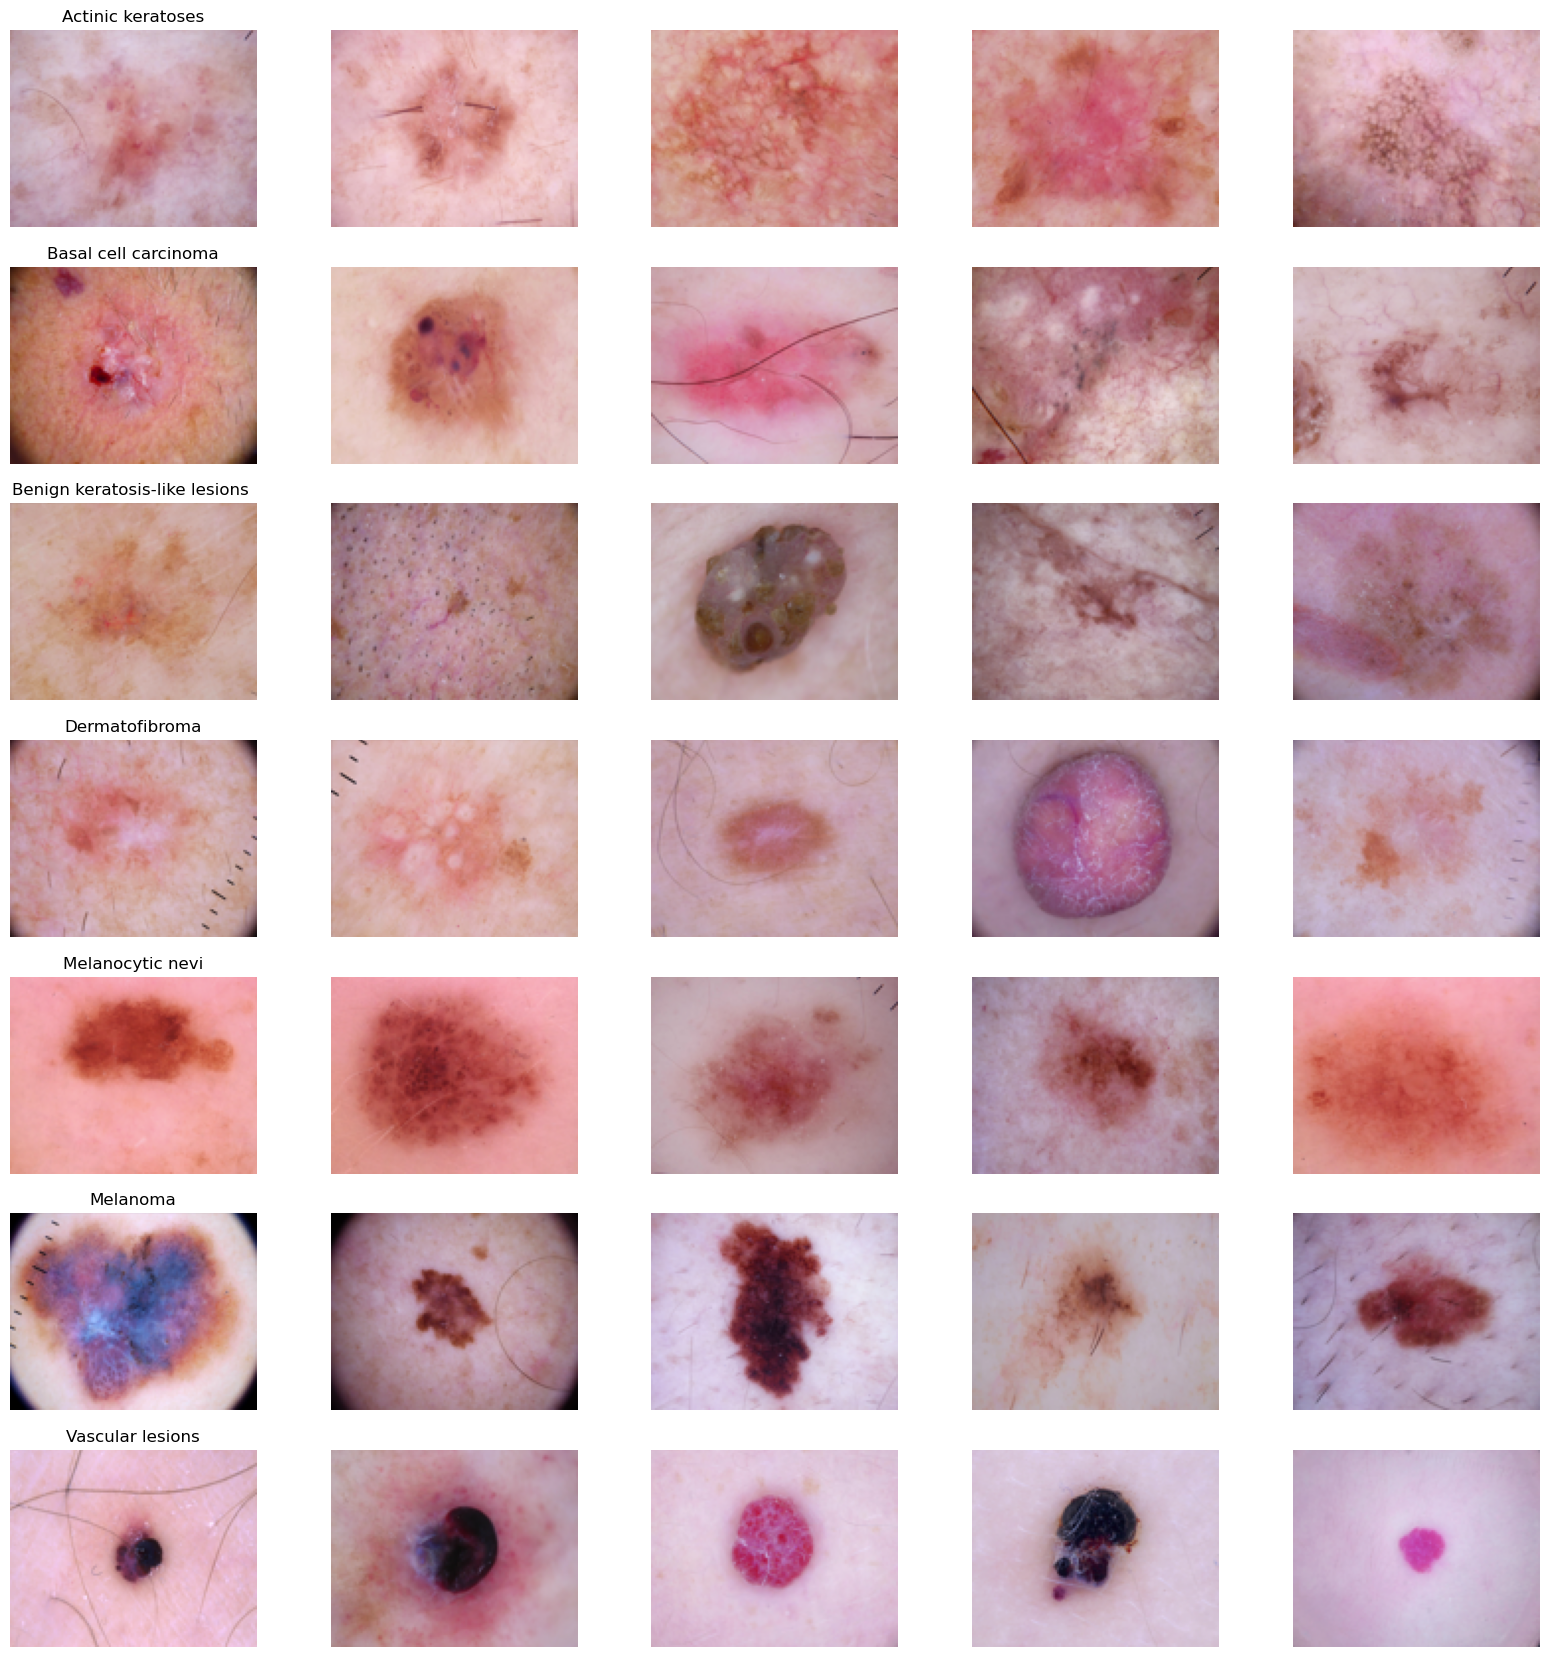

In [37]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
# fig.savefig('category_samples.png', dpi=300)

In [38]:
# See the image size distribution - should just return one row (all images are uniform)
df['image'].map(lambda x: x.shape).value_counts()

image
(100, 125, 3)    10015
Name: count, dtype: int64

In [39]:
#Exploratory Data Analysis
df= df[df['age'] != 0]
df= df[df['sex'] != 'unknown']

<Axes: title={'center': 'CELL TYPE'}, xlabel='cell_type', ylabel='Count'>

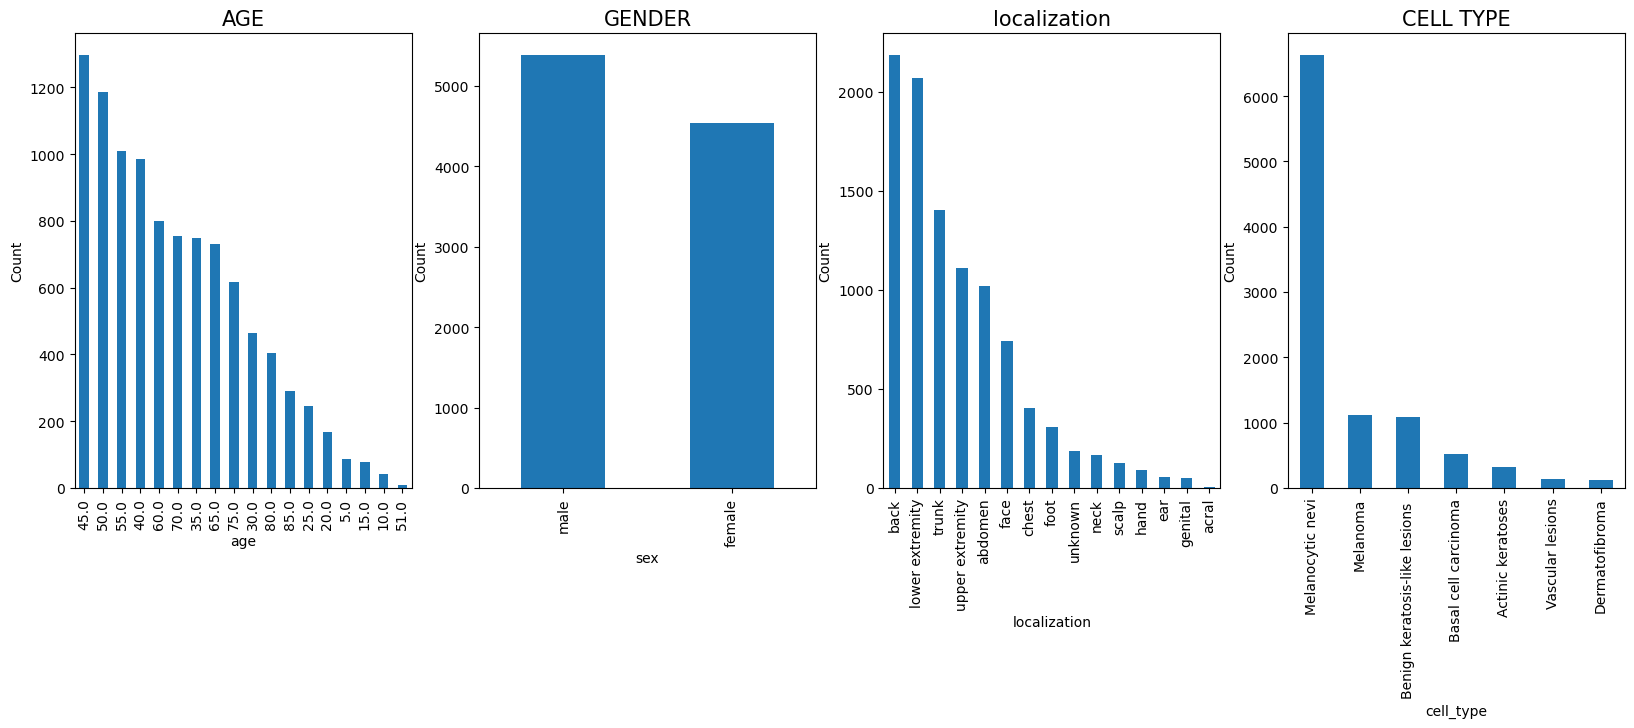

In [41]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(left=0.125, bottom=1, right=0.9, top=2, hspace=0.2)
plt.subplot(2,4,1)
plt.title("AGE",fontsize=15)
plt.ylabel("Count")
df['age'].value_counts().plot.bar()

plt.subplot(2,4,2)
plt.title("GENDER",fontsize=15)
plt.ylabel("Count")
df['sex'].value_counts().plot.bar()

plt.subplot(2,4,3)
plt.title("localization",fontsize=15)
plt.ylabel("Count")
plt.xticks(rotation=45)
df['localization'].value_counts().plot.bar()

plt.subplot(2,4,4)
plt.title("CELL TYPE",fontsize=15)
plt.ylabel("Count")
df['cell_type'].value_counts().plot.bar()

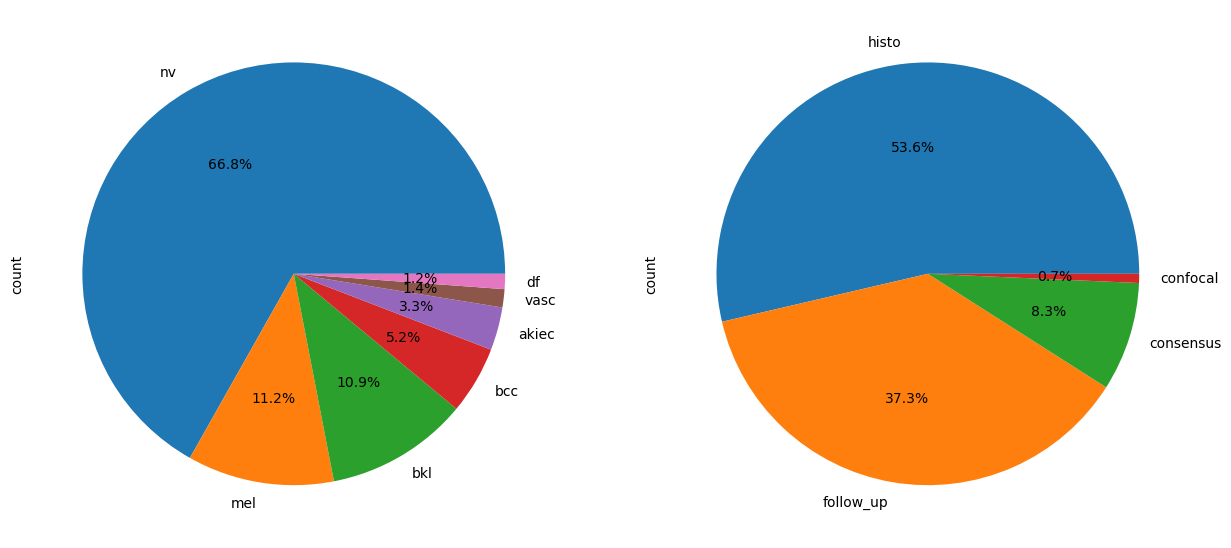

In [42]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
df['dx'].value_counts().plot.pie(autopct="%1.1f%%")
plt.subplot(1,2,2)
df['dx_type'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

<Axes: title={'center': 'LOCALIZATION VS GENDER'}, xlabel='count', ylabel='localization'>

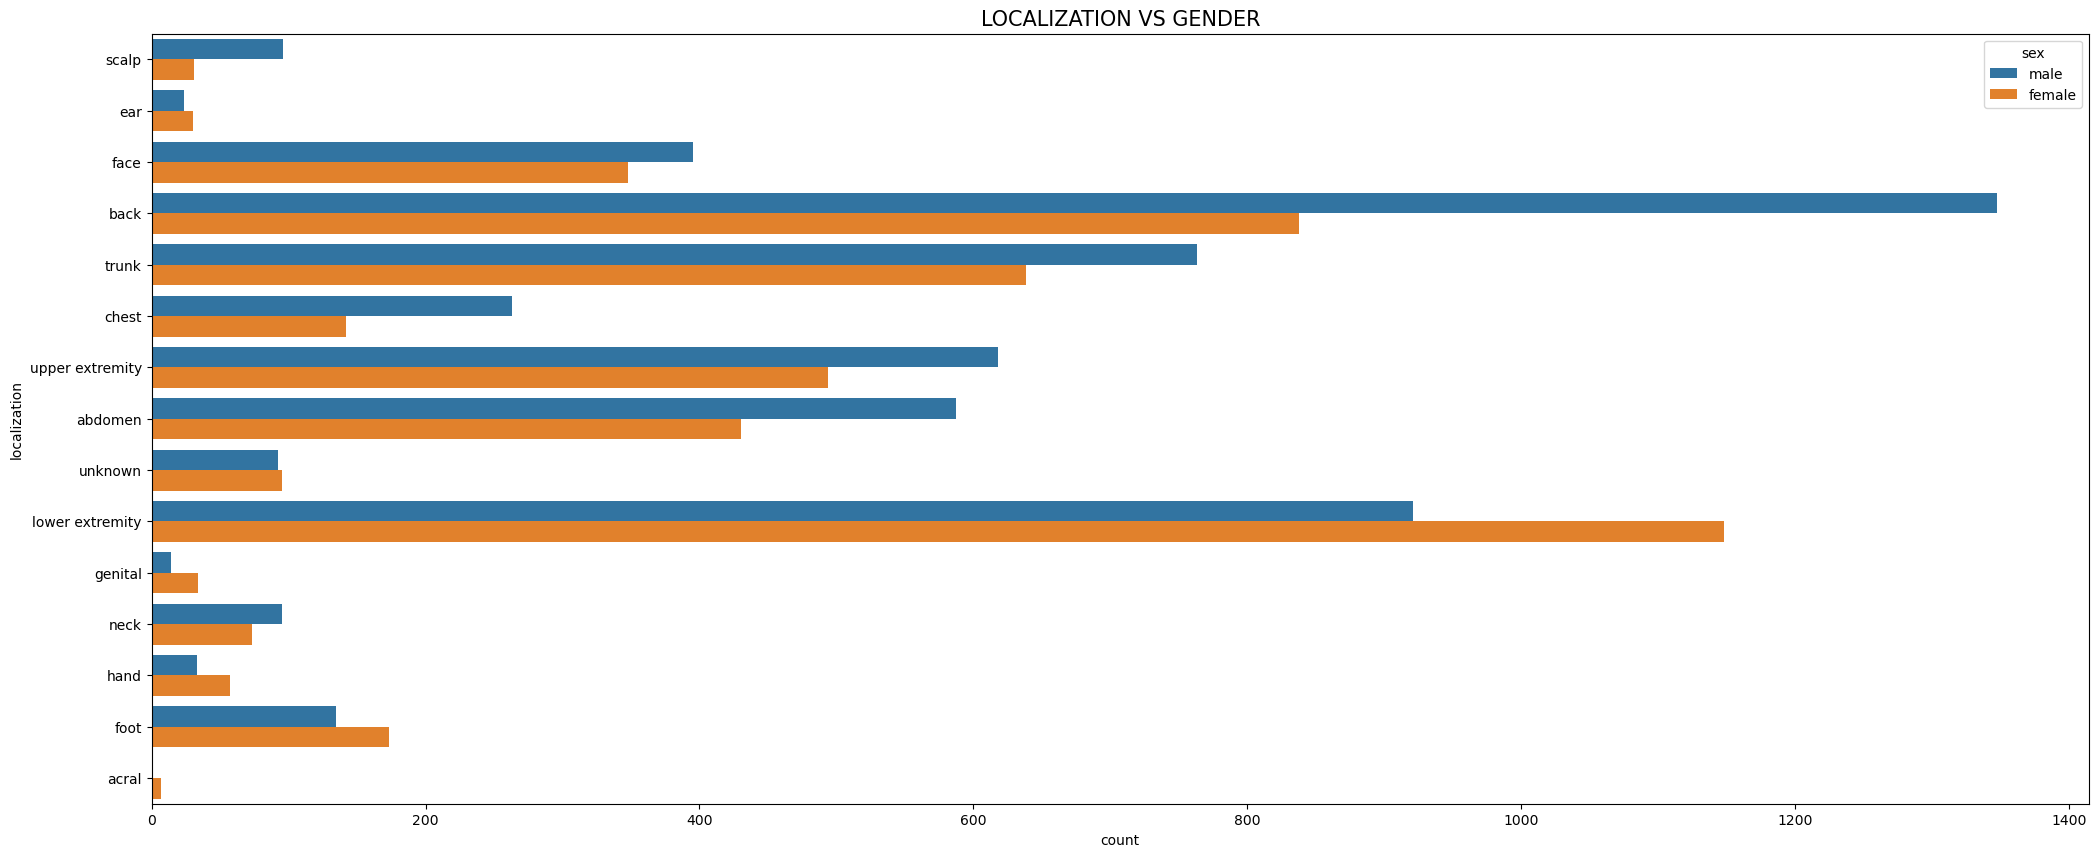

In [43]:
#BIVARIATE ANALYSIS
plt.figure(figsize=(25,10))
plt.title('LOCALIZATION VS GENDER',fontsize = 15)
sns.countplot(y='localization', hue='sex',data=df)

<Axes: title={'center': 'LOCALIZATION VS CELL TYPE'}, xlabel='count', ylabel='localization'>

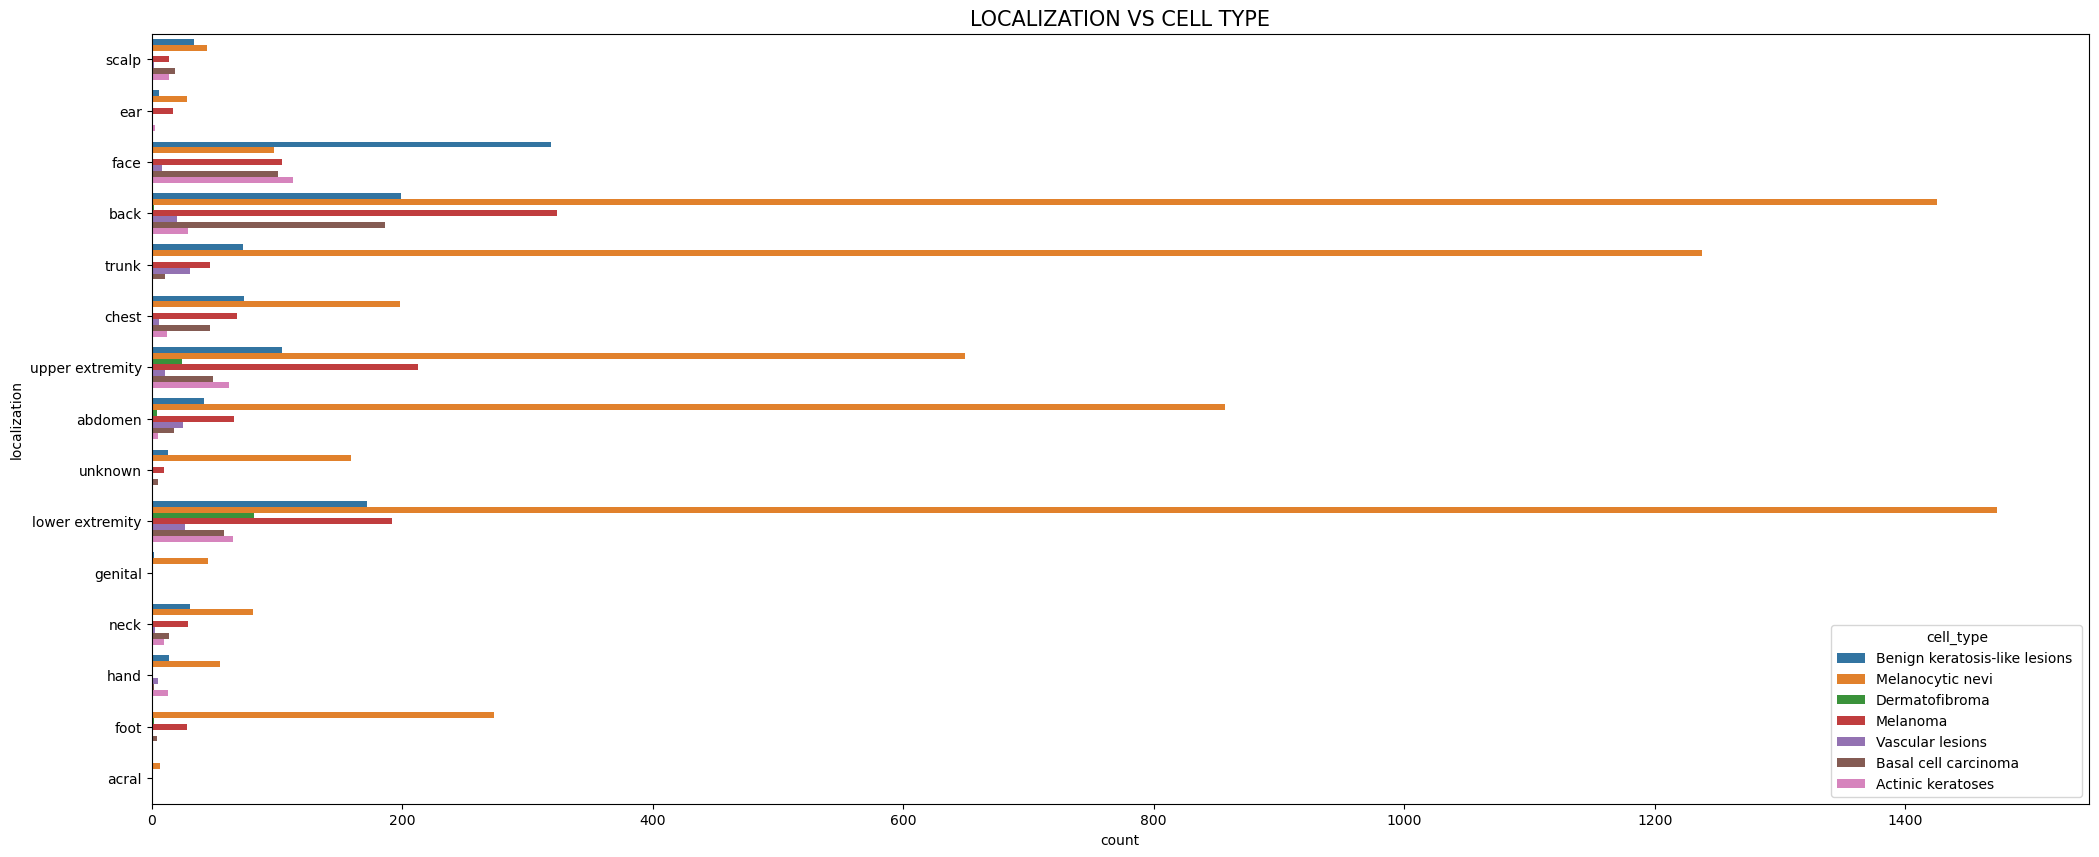

In [44]:
plt.figure(figsize=(25,10))
plt.title('LOCALIZATION VS CELL TYPE',fontsize = 15)
sns.countplot(y='localization', hue='cell_type',data=df)

<Axes: title={'center': 'GENDER VS CELL TYPE'}, xlabel='count', ylabel='sex'>

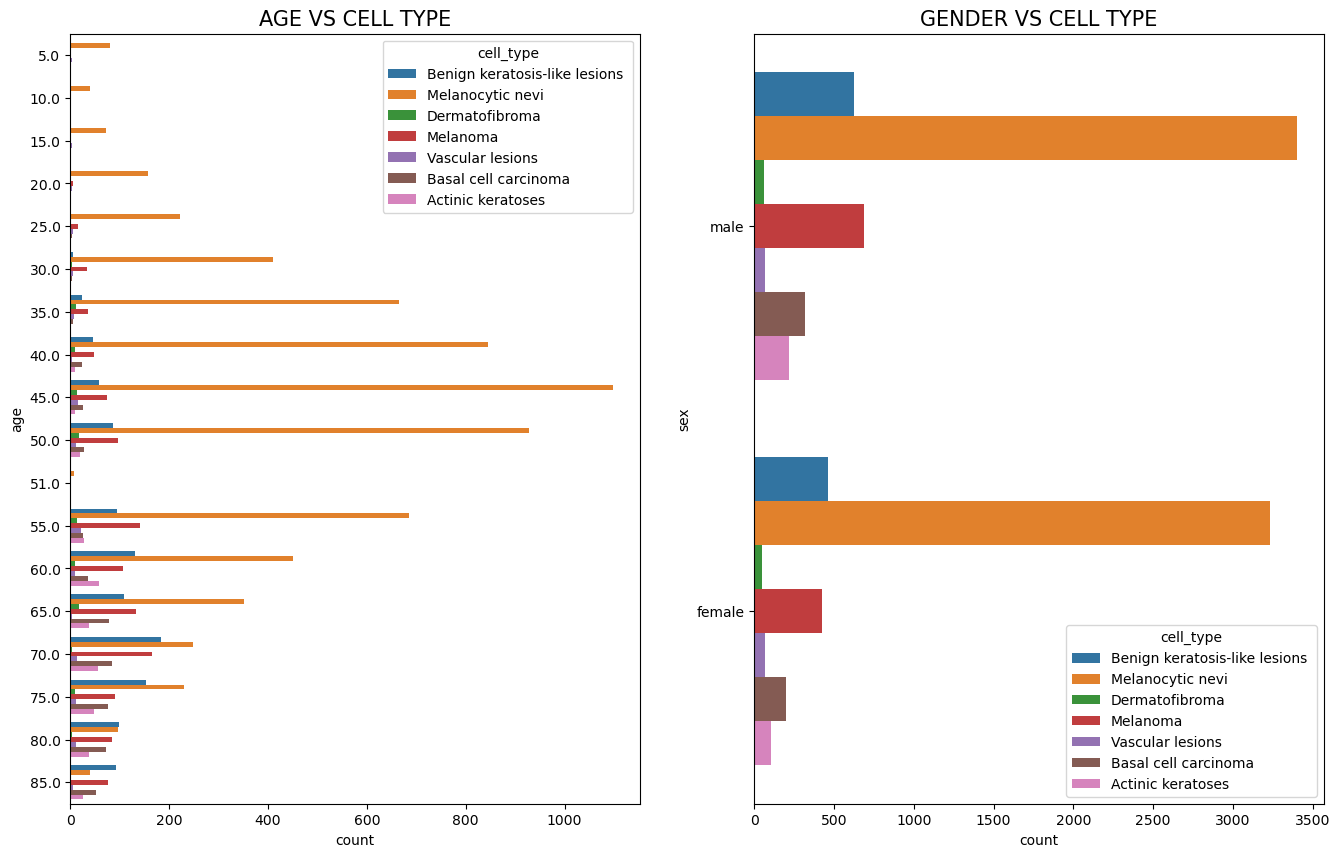

In [45]:
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.title('AGE VS CELL TYPE',fontsize = 15)
sns.countplot(y='age', hue='cell_type',data=df)
plt.subplot(132)
plt.title('GENDER VS CELL TYPE',fontsize = 15)
sns.countplot(y='sex', hue='cell_type',data=df)

In [47]:
# CNN

In [48]:
input_shape = (100, 125, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                 padding='Same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                 padding='Same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.16))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                 padding='Same'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                 padding='Same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.16))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',
                 padding='Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',
                 padding='Same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.summary()






Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 125, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 125, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 62, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 62, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 62, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 62, 32)        9248      
                                                      

In [52]:
# compile

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
features = df.drop(columns=['cell_type_idx'], axis=1)
target=df['cell_type_idx']

In [55]:
features.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,.\HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,"[[[189, 152, 194], [192, 156, 198], [191, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,.\HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,"[[[24, 13, 22], [24, 14, 22], [24, 14, 26], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,.\HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,"[[[186, 127, 135], [189, 133, 145], [192, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,.\HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,"[[[24, 11, 17], [24, 11, 20], [30, 15, 25], [4..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,.\HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,"[[[131, 88, 110], [142, 97, 120], [152, 107, 1..."


In [56]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.25,random_state=666)
tf.unique(x_train_o.cell_type.values)

Unique(y=<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'Melanocytic nevi', b'Basal cell carcinoma', b'Melanoma',
       b'Actinic keratoses', b'Vascular lesions',
       b'Benign keratosis-like lesions ', b'Dermatofibroma'], dtype=object)>, idx=<tf.Tensor: shape=(7440,), dtype=int32, numpy=array([0, 1, 2, ..., 1, 0, 0])>)

In [57]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [59]:
# Perform one-hot encoding on the labels
from keras.utils import to_categorical
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [60]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)
# Reshape image in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(100, 125, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 125, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [61]:
# Fit the model
epochs = 60
batch_size = 16
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              )

from keras.metrics import Recall
from sklearn.metrics import classification_report,confusion_matrix

Epoch 1/60


C:\Users\asiae\AppData\Local\Temp\ipykernel_20916\2655155827.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


418/418 [==============================] - 37s 85ms/step - loss: 1.0343 - accuracy: 0.6603 - val_loss: 0.9205 - val_accuracy: 0.6707
Epoch 2/60
418/418 [==============================] - 37s 89ms/step - loss: 0.9473 - accuracy: 0.6699 - val_loss: 0.8597 - val_accuracy: 0.6922
Epoch 3/60
418/418 [==============================] - 38s 91ms/step - loss: 0.9058 - accuracy: 0.6759 - val_loss: 0.9621 - val_accuracy: 0.6815
Epoch 4/60
418/418 [==============================] - 37s 89ms/step - loss: 0.8687 - accuracy: 0.6885 - val_loss: 0.7885 - val_accuracy: 0.7218
Epoch 5/60
418/418 [==============================] - 38s 90ms/step - loss: 0.8462 - accuracy: 0.6990 - val_loss: 0.8068 - val_accuracy: 0.7030
Epoch 6/60
418/418 [==============================] - 37s 88ms/step - loss: 0.8274 - accuracy: 0.7030 - val_loss: 0.7651 - val_accuracy: 0.7272
Epoch 7/60
418/418 [==============================] - 36s 86ms/step - loss: 0.8021 - accuracy: 0.7121 - val_loss: 0.7599 - val_accuracy: 0.7312
Epo

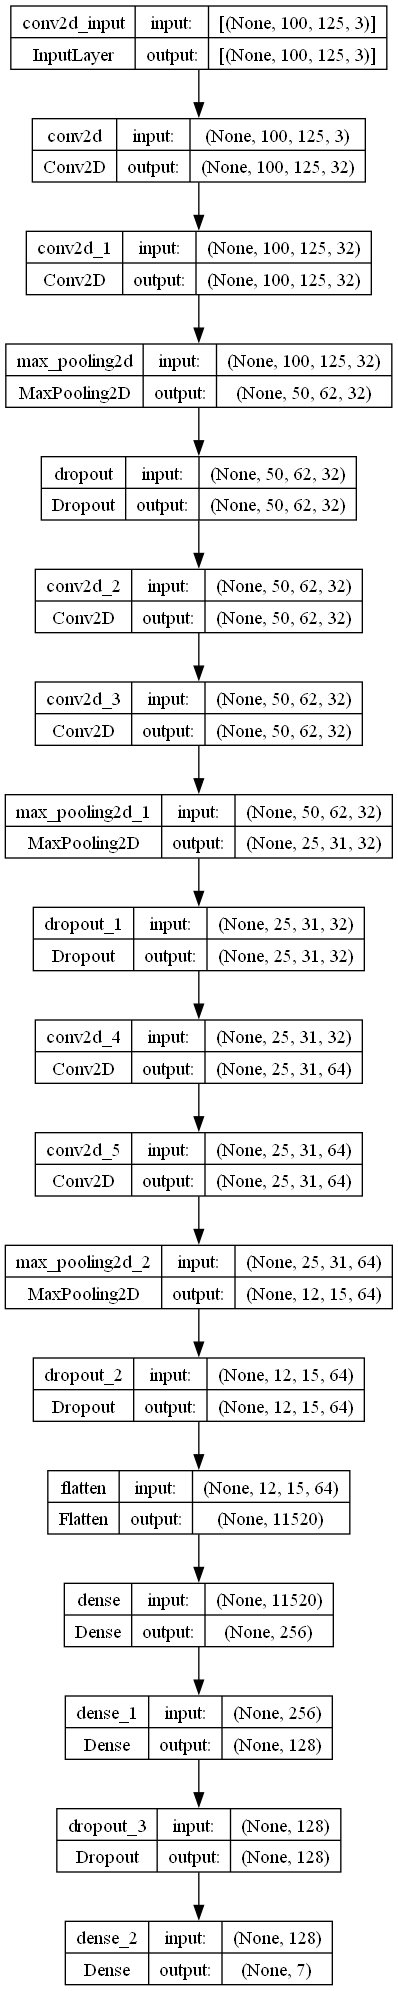

In [63]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [68]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.034329,0.660329,0.920503,0.670699
1,0.947286,0.669910,0.859663,0.692204
2,0.905802,0.675898,0.962069,0.681452
3,0.868720,0.688473,0.788508,0.721774
4,0.846229,0.698952,0.806757,0.702957
5,0.827394,0.702994,0.765134,0.727151
6,0.802149,0.712126,0.759926,0.731183
7,0.794132,0.716317,0.734538,0.727151
8,0.783536,0.720359,0.732948,0.733871
9,0.764176,0.718713,0.707997,0.739247


In [64]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

24/24 [==============================] - 1s 33ms/step - loss: 0.6422 - accuracy: 0.7648
Validation: accuracy = 0.764785  ;  loss_v = 0.642250
Test: accuracy = 0.777912  ;  loss = 0.631887


24/24 [==============================] - 1s 29ms/step


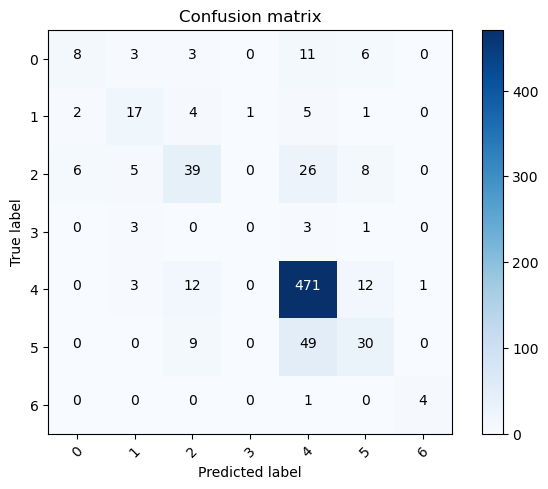

In [66]:
import itertools
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

78/78 [==============================] - 3s 32ms/step


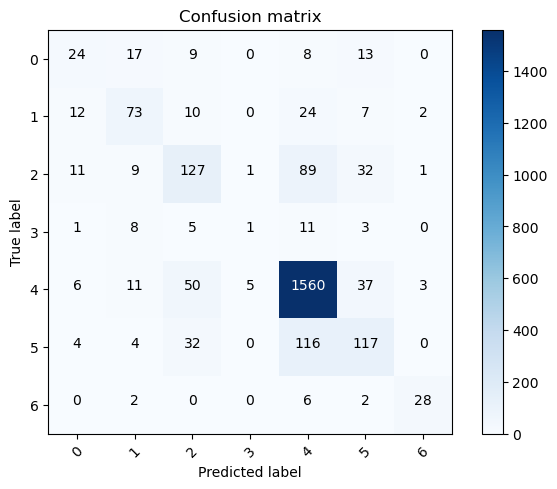

In [67]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

In [76]:
from keras.preprocessing.image import load_img, img_to_array

image = load_img('./img_skincancer.png', target_size=(100, 125))
image = img_to_array(image)
image = image.reshape((1, 100, 125, 3))

y_pred_proba = model.predict(image)
np.argmax(y_pred_proba)



1/1 [==============================] - 0s 23ms/step


3569    4
3781    4
9128    4
303     2
5709    4
       ..
8230    4
5326    4
8786    4
1410    5
7411    4
Name: cell_type_idx, Length: 2481, dtype: int8